# Training with image data for capybaras and other rodents

*adapted from fastai course lesson 2*

Web app is at https://capydetector.herokuapp.com/ .  (It may take a minute to warm up.)

**Setup Fastai for colab**

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

**Set up Google Drive**

Training images and test images are stored on Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


**Import fastai and set up paths**

Image data is in separate folders under the rodent_dir directory, with folder names corresponding to image labels.  Test images are in the testbatch directory.  

Images are from image search and private sources.  (Dogs and cats are included in case people upload photos of their pets.)

In [0]:
from fastai.vision import *
rodent_dir = "/content/gdrive/My Drive/rodents"
gpath = pathlib.Path(rodent_dir)
test_dir = "/content/gdrive/My Drive/testbatch"
tpath = pathlib.Path(test_dir)
gpath.ls()

[PosixPath('/content/gdrive/My Drive/rodents/pacarana'),
 PosixPath('/content/gdrive/My Drive/rodents/agouti'),
 PosixPath('/content/gdrive/My Drive/rodents/capybara'),
 PosixPath('/content/gdrive/My Drive/rodents/nutria'),
 PosixPath('/content/gdrive/My Drive/rodents/models'),
 PosixPath('/content/gdrive/My Drive/rodents/rabbit'),
 PosixPath('/content/gdrive/My Drive/rodents/guineapig'),
 PosixPath('/content/gdrive/My Drive/rodents/squirrel'),
 PosixPath('/content/gdrive/My Drive/rodents/chinchilla'),
 PosixPath('/content/gdrive/My Drive/rodents/cat'),
 PosixPath('/content/gdrive/My Drive/rodents/degu'),
 PosixPath('/content/gdrive/My Drive/rodents/export.pkl'),
 PosixPath('/content/gdrive/My Drive/rodents/beaver'),
 PosixPath('/content/gdrive/My Drive/rodents/dog')]

**Create databunch, then normalize**

In [0]:
np.random.seed(8)
data = ImageDataBunch.from_folder(rodent_dir, valid_pct=0.19, size=224)

In [0]:
data.normalize()

**Take a peek at some data**

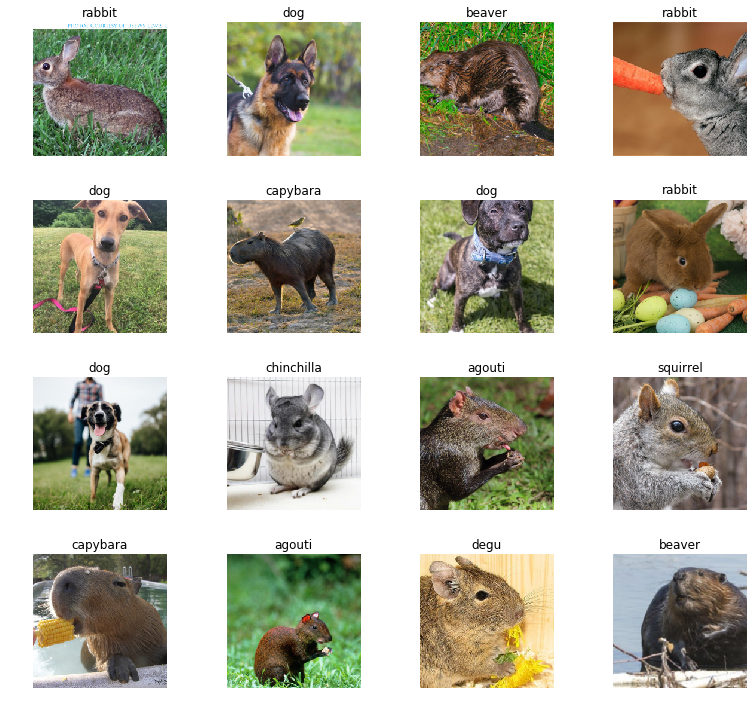

In [0]:
data.show_batch(rows=4, figsize=(11,10))


**Check class names**

In [0]:
print(data.classes)
len(data.classes),data.c



['agouti', 'beaver', 'capybara', 'cat', 'chinchilla', 'degu', 'dog', 'guineapig', 'nutria', 'pacarana', 'rabbit', 'squirrel']


(12, 12)

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['agouti',
  'beaver',
  'capybara',
  'cat',
  'chinchilla',
  'degu',
  'dog',
  'guineapig',
  'nutria',
  'pacarana',
  'rabbit',
  'squirrel'],
 12,
 2624,
 656)

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.143537,0.192662,0.045016,01:42
1,0.489022,0.139470,0.041801,01:41
2,0.248251,0.112317,0.030547,01:41
3,0.137679,0.108520,0.035370,01:43


In [0]:
learn.save('stage-1')

**Check learning curve and try retraining based on that.**

In [0]:
learn.load('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

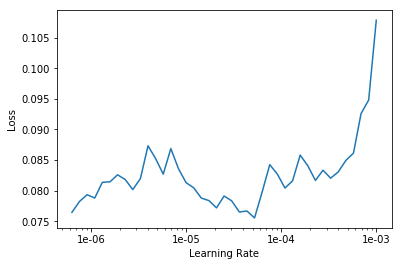

In [0]:
learn.recorder.plot()


In [0]:
# If the plot is not showing try to give a start and end learning rate# learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(9e-6,3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.068971,0.034865,0.011254,01:43
1,0.055397,0.034006,0.011254,01:43
2,0.040345,0.033208,0.009646,01:45
3,0.029612,0.030663,0.008039,01:42


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

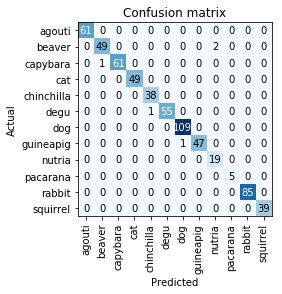

In [0]:
interp.plot_confusion_matrix()

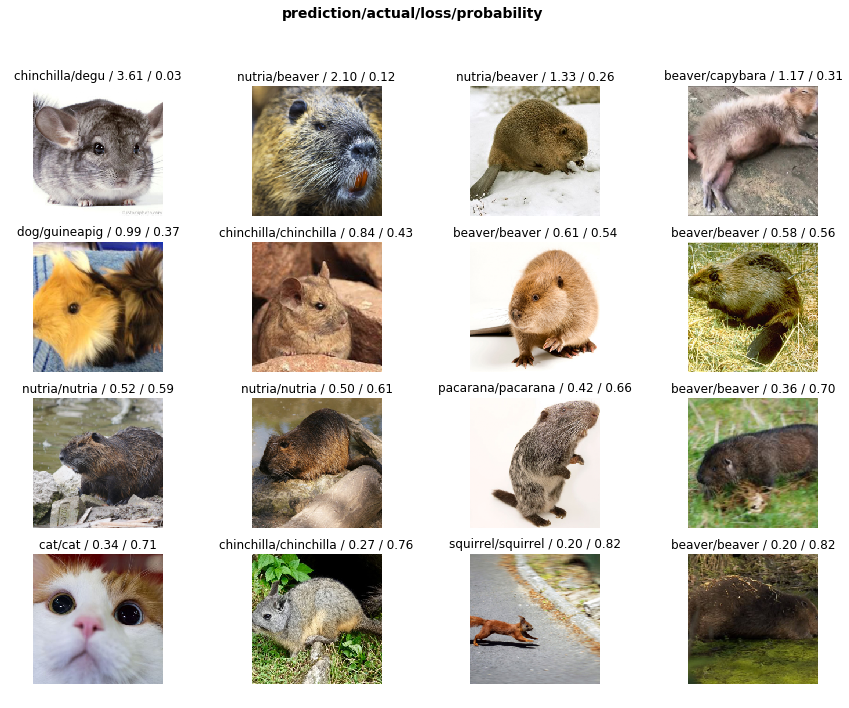

In [0]:
interp.plot_top_losses(16, heatmap=False, figsize=(15,11))


## Put the model into production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

In [0]:
learn = load_learner(gpath)

In [0]:
def top_perc(thetensor):
	perclist = []
	for j in range(len(thetensor)):
		oneperc = thetensor[j].item()
		perclist.append(oneperc)
	maxperc = round((max(perclist)*100), 2)
	maxix = perclist.index(max(perclist))
	return maxperc

def pred_results(pred_class, outputs):
	maxperc = top_perc(outputs)
	rstr = "Category: " + str(pred_class) + ", confidence: " + str(maxperc)
	return rstr

In [0]:
petcount = 0

In [0]:
data.classes


['agouti',
 'beaver',
 'capybara',
 'cat',
 'chinchilla',
 'degu',
 'dog',
 'guineapig',
 'nutria',
 'pacarana',
 'rabbit',
 'squirrel']

In [0]:
categories = data.classes

Try a test image

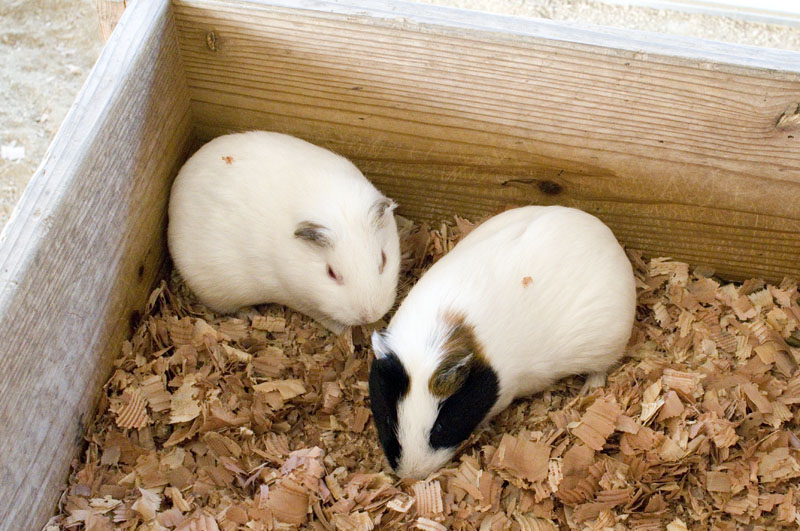

In [0]:
img = open_image(tpath/'gui-001.jpg')
img

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_results(pred_class, outputs)

'Category: guineapig, confidence: 74.37'

In [0]:
print (outputs)


tensor([0.0116, 0.0152, 0.0028, 0.0024, 0.0100, 0.0028, 0.0757, 0.7437, 0.0066,
        0.0032, 0.1226, 0.0036])


Test several images and report results

In [0]:
imagenames = ['cap-038.jpg', 'cap-037.jpg', 'cap-036.jpg', 'cap-035.jpg', 'cap-034.jpg', 'cap-033.jpg', 'dog-001.jpg', 'dog-002.jpg',
             'dog-003.jpg', 'dog-004.jpg', 'dog-005.jpg', 'dog-006.jpg', 'dog-007.jpg', 'dog-008.jpg', 'bea.jpg', 'cat-001.jpg', 'cat-002.jpg', 
             'cat-003.jpg', 'cat-004.jpg', 'cat-005.jpg', 'cat-006.jpg', 'cat.jpg', 'rab-001.jpg', 'rab-002.jpg', 'rab-003.jpg']
resultlist = []
for imagename in imagenames:
	#imgplus = "tpath/" + imagename
	img = open_image(tpath/imagename)
	pred_class,pred_idx,outputs = learn.predict(img)
	oneresult = imagename + ": " + pred_results(pred_class, outputs)	
	resultlist.append(oneresult)
for oneresult in resultlist:
	print (oneresult)

cap-038.jpg: Category: capybara, confidence: 99.54
cap-037.jpg: Category: capybara, confidence: 99.87
cap-036.jpg: Category: capybara, confidence: 96.64
cap-035.jpg: Category: capybara, confidence: 99.96
cap-034.jpg: Category: capybara, confidence: 76.3
cap-033.jpg: Category: capybara, confidence: 66.02
dog-001.jpg: Category: dog, confidence: 99.36
dog-002.jpg: Category: dog, confidence: 98.21
dog-003.jpg: Category: dog, confidence: 90.73
dog-004.jpg: Category: dog, confidence: 99.28
dog-005.jpg: Category: dog, confidence: 99.99
dog-006.jpg: Category: dog, confidence: 99.86
dog-007.jpg: Category: dog, confidence: 99.21
dog-008.jpg: Category: dog, confidence: 99.94
bea.jpg: Category: beaver, confidence: 92.35
cat-001.jpg: Category: cat, confidence: 99.54
cat-002.jpg: Category: cat, confidence: 99.98
cat-003.jpg: Category: cat, confidence: 99.96
cat-004.jpg: Category: cat, confidence: 99.21
cat-005.jpg: Category: cat, confidence: 99.95
cat-006.jpg: Category: cat, confidence: 93.52
cat.jp